# HFSS vs ANITITER II benchmark

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, pi

## Coupling resistance and impedances

In [2]:
results = pd.DataFrame(columns=['Scenario', 'Source',  'Ra', 'ReZ11', 'ImZ11', 'ReZ21', 'ImZ21']  )
res= [
    {'Scenario': '1e15 to 5e18', 'Source': 'HFSS', 'Ra': 0.094, 'ReZ11':0.31, 'ImZ11':23.5, 'ReZ21':0.29, 'ImZ21':3.96},
    {'Scenario': '1e15 to 5e18', 'Source': 'ANTITER', 'Ra': 0.096, 'ReZ11':0.32, 'ImZ11':23.13, 'ReZ21':0.31, 'ImZ21':3.22},
    {'Scenario': '1e15 to 10e18', 'Source': 'HFSS', 'Ra': 0.23, 'ReZ11': 0.498, 'ImZ11':23.69, 'ReZ21':0.46, 'ImZ21':4.05},
    {'Scenario': '1e15 to 10e18', 'Source': 'ANTITER', 'Ra': 0.25, 'ReZ11':0.5, 'ImZ11':23.01, 'ReZ21':	0.45, 'ImZ21':3.12},
]
results = results.append(res, ignore_index=True, )

In [3]:
# relative difference between HFSS and ANTITER
res_HFSS = results.loc[results.Source=='HFSS']
res_ATT = results.loc[results.Source=='ANTITER']
res_HFSS

,Scenario,Source,Ra,ReZ11,ImZ11,ReZ21,ImZ21
0,1e15 to 5e18,HFSS,0.094,0.310,23.50,0.29,3.96
2,1e15 to 10e18,HFSS,0.230,0.498,23.69,0.46,4.05


In [4]:
_res = []
_res2 = pd.DataFrame()
for sc in res_ATT.Scenario:
    _ATT_val = res_ATT.loc[res_ATT.Scenario == sc][['Ra', 'ReZ11', 'ImZ11', 'ReZ21', 'ImZ21']].values
    _HFSS_val = res_HFSS.loc[res_HFSS.Scenario == sc][['Ra', 'ReZ11', 'ImZ11', 'ReZ21', 'ImZ21']].values
    _res.append((_ATT_val - _HFSS_val)/_ATT_val*100)

rel_diffs = np.array(_res).squeeze()

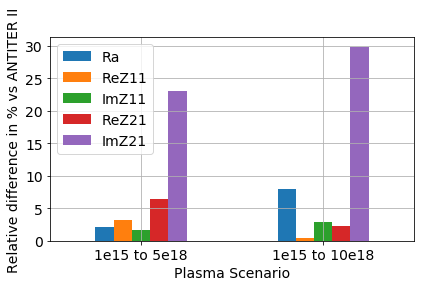

In [6]:
res_diff = pd.DataFrame(np.abs(rel_diffs), columns=['Ra', 'ReZ11', 'ImZ11', 'ReZ21', 'ImZ21'], index=res_ATT.Scenario)
ax=res_diff.plot.bar(rot=0, fontsize=14)
ax.grid(True)
ax.set_xlabel('Plasma Scenario', fontsize=14)
ax.set_ylabel('Relative difference in % vs ANTITER II', fontsize=14)
ax.legend(fontsize=14)
plt.tight_layout()
plt.savefig('relative_differences.png')

## $k_\parallel$ spectrum

In [7]:
def physfft(x, y):
    """
    Return the fourier transform of signal y(x) as physically-defined as: 
    Y(k) = 1/2pi int_-inf^+inf y(x) e^-ikx dx
    from https://www.iap.uni-jena.de/iapmedia/de/Lecture/Computational+Photonics1472680800/CPho16_Seminar7_FFT_Primer.pdf
    
    """
    # spatial sampling distance
    delta_x = x[1] - x[0] # assume constant sampling distance
    # Number of spatial points
    N = len(x)  # assume x and y have same length
    # spatial bandwith
    L = delta_x * N   
    # spectral sampling distance
    delta_k = 2*pi/L
    # forge the k vector
    m = np.arange(-np.floor(N/2), np.ceil(N/2))
    k = m*2*pi/L
    
    Y =  delta_x/(2*pi)*np.exp(-1j*2*pi/L*x[0]*m) * np.fft.fftshift(np.fft.fft(y, axis=1))
    
    return k, Y

def calculate_spectrum(z, E, H, f=3.7e9):
    """
    Calculate the spectral power density spectrum 
    along the toroidal index (n_parallel) from the E and H fields
    """        
    kz, Efft = physfft(z, E)
    kz, Hfft = physfft(z, H)
    
    # ~ power density spectrum
    p = 1/2*(Efft[1] * np.conj(Hfft[2]) -  Efft[2] * np.conj(Hfft[1])   )
    p = 1/2*(Efft[1] * np.conj(Hfft[2])   )
    #p = (dz)**2/lambda0 * 1/2*np.cross(Efft, np.conj(Hfft), axis=0)[0]  # x-component  
       
    return kz, p

Now we need a routine to import the electromagnetic field exported along a line from HFSS

In [8]:
k0 = 2*pi*50e6/c

In [9]:
def import_HFSS_fld(filename):
    #HFSS fld are particularly badly made. They use both space and tab separator, 
    # label NaN as "Nan", etc... Anyway, we can still achieve it:
    data=pd.read_csv(filename, 
                skiprows=2, index_col=False, delim_whitespace=True, na_values='Nan',
               names=['X', 'Y', 'Z', 'AxRe', 'AxIm', 'AyRe', 'AyIm', 'AzRe', 'AzIm']).fillna(0)
    # Create the complex-valued vector components
    data['Ax'] = data.AxRe + 1j*data.AxIm
    data['Ay'] = data.AyRe + 1j*data.AyIm
    data['Az'] = data.AzRe + 1j*data.AzIm
    R = np.array([data.X, data.Y, data.Z])
    A = np.array([data.Ax, data.Ay, data.Az])
    return R, A


In [53]:
R, E = import_HFSS_fld('results_HFSS/HFSS_2s_lin_05e18_Efield_plasma_1cm.fld')
R, H = import_HFSS_fld('results_HFSS/HFSS_2s_lin_05e18_Hfield_plasma_1cm.fld')
kz, p = calculate_spectrum(-R[2], E, H, f=50e6)

#R_FS, E_FS = import_HFSS_fld('results_HFSS/HFSS_2s_lin_05e18_Efield_plasma_1cm_FS.fld')
#R_FS, H_FS = import_HFSS_fld('results_HFSS/HFSS_2s_lin_05e18_Hfield_plasma_1cm_FS.fld')
#kz_FS, p_FS = calculate_spectrum(-R_FS[2], E_FS, H_FS, f=50e6)

R2, E2 = import_HFSS_fld('results_HFSS/HFSS_2s_lin_05e18_Efield_dielectric_1cm.fld')
R2, H2 = import_HFSS_fld('results_HFSS/HFSS_2s_lin_05e18_Hfield_dielectric_1cm.fld')
kz2, p2 = calculate_spectrum(-R2[2], E2, H2, f=50e6)

C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


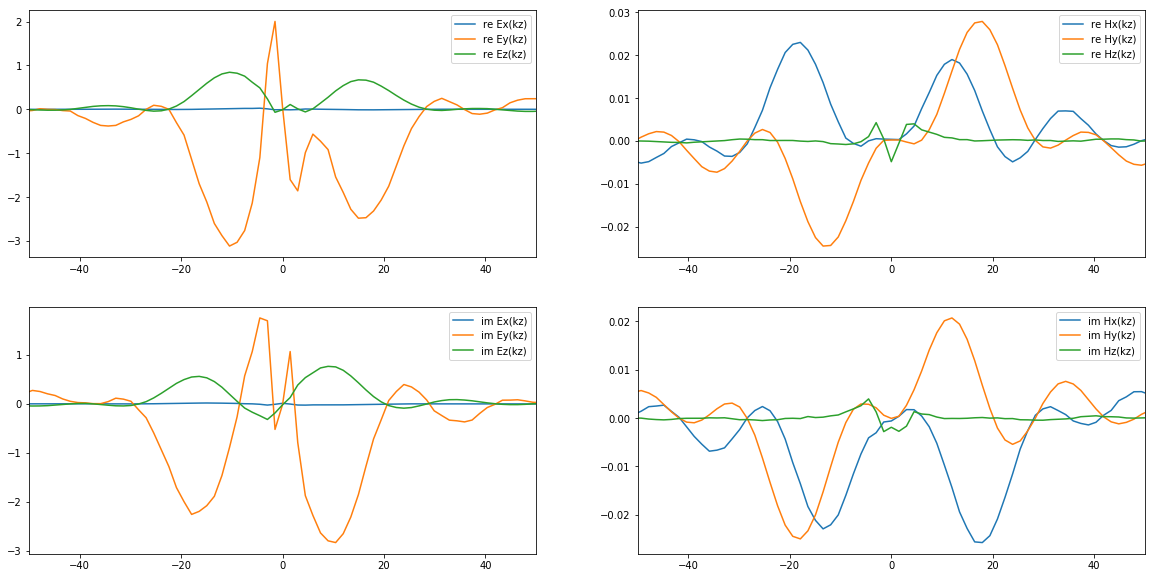

In [54]:
k, Ek = physfft(R[2], E)
k, Hk = physfft(R[2], H)
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0,0].plot(k, Ek[0], label='re Ex(kz)')
ax[0,0].plot(k, Ek[1], label='re Ey(kz)' )
ax[0,0].plot(k, Ek[2], label='re Ez(kz)')
ax[0,0].set_xlim(-50, 50)
ax[0,0].legend()
ax[1,0].plot(k, np.imag(Ek[0]), label='im Ex(kz)')
ax[1,0].plot(k, np.imag(Ek[1]), label='im Ey(kz)' )
ax[1,0].plot(k, np.imag(Ek[2]), label='im Ez(kz)')
ax[1,0].set_xlim(-50, 50)
ax[1,0].legend()
ax[0,1].plot(k, Hk[0], label='re Hx(kz)')
ax[0,1].plot(k, Hk[1], label='re Hy(kz)' )
ax[0,1].plot(k, Hk[2], label='re Hz(kz)')
ax[0,1].set_xlim(-50, 50)
ax[0,1].legend()
ax[1,1].plot(k, np.imag(Hk[0]), label='im Hx(kz)')
ax[1,1].plot(k, np.imag(Hk[1]), label='im Hy(kz)' )
ax[1,1].plot(k, np.imag(Hk[2]), label='im Hz(kz)')
ax[1,1].set_xlim(-50, 50)
ax[1,1].legend()

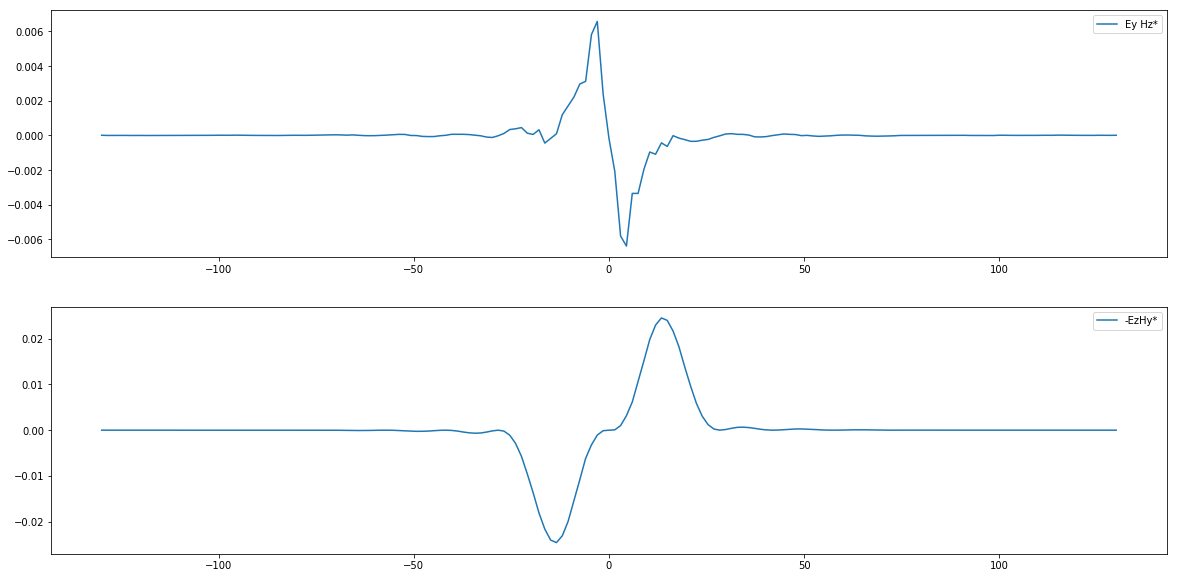

In [56]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(k, np.real(Ek[1] * np.conj(Hk[2])), label='Ey Hz*')
ax[0].legend()
ax[1].plot(k, np.real(Ek[2] * np.conj(Hk[1])), label='-EzHy*')
ax[1].legend()

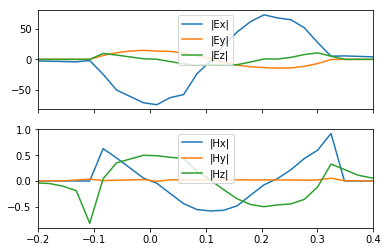

In [11]:
fig,ax=plt.subplots(2, 1, sharex=True)
ax[0].plot(R[2], np.real(E[0]), label='|Ex|')
ax[0].plot(R[2], np.real(E[1]), label='|Ey|')
ax[0].plot(R[2], np.real(E[2]), label='|Ez|')
ax[0].legend()
ax[0].set_xlim(-0.2, 0.4)

ax[1].plot(R[2], np.real(H[0]), label='|Hx|')
ax[1].plot(R[2], np.real(H[1]), label='|Hy|')
ax[1].plot(R[2], np.real(H[2]), label='|Hz|')
ax[1].legend()

fig.savefig('EH_fields.png')

(-30, 30)

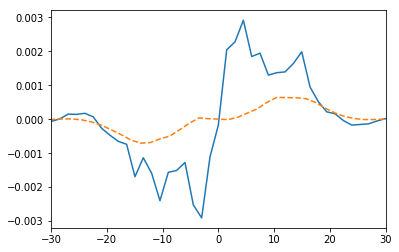

In [12]:
fig,ax=plt.subplots()
ax.plot(kz, np.real(p))
#ax.plot(kz_FS, np.real((p_FS)))
ax.plot(kz2, np.real((p2)), '--')
ax.set_xlim(-30,30)

In [13]:
k_par, Ra = np.loadtxt('results_ANTITERII/Spectr_2s_lin_10e18.txt', skiprows=1, unpack=True)

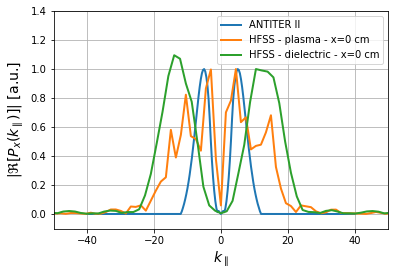

In [14]:
fig, ax = plt.subplots()
ax.plot(k_par, Ra/np.max(Ra), label="ANTITER II", lw=2)
ax.plot(kz, np.abs(np.real(p))/np.max(np.real(p)), label='HFSS - plasma - x=0 cm', lw=2)
#ax.plot(kz_FS, np.abs(np.real(p_FS))/np.max(np.real(p_FS)), label='HFSS - plasma+FS - x=1 cm', lw=2)
ax.plot(kz2, np.abs(np.real(p2))/np.max(np.real(p2)), label='HFSS - dielectric - x=0 cm', lw=2)
ax.set_ylabel('$| \Re[ P_x(k_\parallel) ]  |$ [a.u.]', fontsize=14)
ax.set_xlabel('$k_\parallel$', fontsize=14)
ax.set_xlim(-50,50)
ax.set_ylim(-0.1,1.4)
ax.legend(loc='best')
ax.grid(True)
fig.savefig('IC_spectra.png')

## Parameters vs gradient

Here we look at the antenna parameters for various gradient, with a linear density increase. 

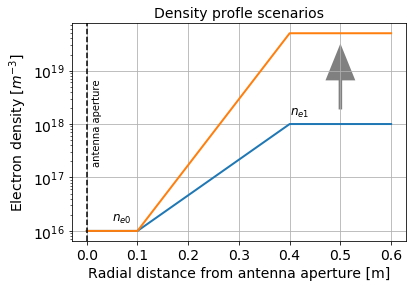

In [241]:
ne_0 = 10e15
ne_1 = [1e18, 50e18]

fig, ax = plt.subplots()
ax.plot([0, 0.1, 0.1, 0.3+0.1, 0.5+0.1], [ne_0, ne_0, ne_0, ne_1[0], ne_1[0]], lw=2)
ax.plot([0, 0.1, 0.1, 0.3+0.1, 0.5+0.1], [ne_0, ne_0, ne_0, ne_1[1], ne_1[1]], lw=2)
ax.set_yscale('log')
ax.set_ylabel('Electron density $[m^{-3}]$', fontsize=14)
ax.set_xlabel('Radial distance from antenna aperture [m]', fontsize=14)
ax.axvline(0, ls='--', color='k')
ax.text(0.01, 5e18, 'antenna aperture', rotation=90)
ax.grid(True)
ax.set_title('Density profle scenarios', fontsize=14)
ax.tick_params(labelsize=14)
ax.arrow(x=0.5, y=2e18, dx=0, dy=0.5e19, color='gray', lw=3, head_width = 0.05, head_length=2e19)
ax.text(0.05, 1.5e16, '$n_{e0}$', fontsize=12)
ax.text(0.4, 1.5e18, '$n_{e1}$', fontsize=12)
fig.savefig('plasma_density_scenario.png')

In [192]:
K_D1, Ra1, Ra2 = np.loadtxt('results_HFSS/Ra vs K_D1.csv', skiprows=1, delimiter=',', unpack=True)

In [184]:
 # pay attention to the space between ''+'', it crashes the conversion to complex numbers !
K_D1, Z11, Z21 = np.loadtxt('results_HFSS/Z vs K_D1.csv', skiprows=1, delimiter=',', dtype=complex, unpack=True,
                           converters={1: lambda s: complex(s.decode().replace(' ','').replace('i', 'j')),
                                               2: lambda s: complex(s.decode().replace(' ','').replace('i', 'j'))
                                      })
# pandas version
#df=pd.read_csv('results_HFSS/Z vs K_D1.csv', sep=',',names=['K_D1', 'Z11', 'Z21'], index_col=0, skiprows=1)
#df.Z11 = df.Z11.str.replace(' ', '').str.replace('i', 'j').apply(lambda x: np.complex(x))
#df.Z21 = df.Z21.str.replace(' ', '').str.replace('i', 'j').apply(lambda x: np.complex(x))

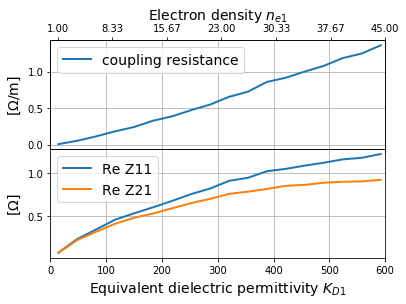

In [233]:
fig, ax = plt.subplots(2, 1, sharex=True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
ax[0].plot(K_D1, Ra1, label='coupling resistance', lw=2)
ax_top = ax[0].twiny()
ax_top.set_xticks(np.linspace(1, 45, 7, endpoint=True))
ax_top.set_xlabel('Electron density $n_{e1}$', fontsize=14)
ax[0].set_ylabel('[$\Omega$/m]', fontsize=14)
ax[1].plot(K_D1, np.real(Z11), label='Re Z11', lw=2)
ax[1].plot(K_D1, np.real(Z21), label='Re Z21', lw=2)
ax[1].set_xlabel('Equivalent dielectric permittivity $K_{D1}$', fontsize=14)
ax[1].set_ylabel('[$\Omega$]', fontsize=14)
[a.grid(True) for a in ax] 
[a.legend(fontsize=14) for a in ax]
ax[1].set_xlim(0, 600)

fig.savefig('Ra_Z_vs_KD1.png')

### CSS Stylin'

In [15]:
from IPython.core.display import HTML

def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """

   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)
_set_css_style('../custom.css')